In [1]:
import cv2
import matplotlib.pyplot as plt
import os
import paddle as paddle
import paddle.fluid as fluid
import PIL.Image as Image
import random
import numpy as np
import time
from PIL import ImageEnhance

In [2]:
def load_model(model_id):
    model_net_path = 'models/infer_model/'+str(model_id)+'/'
    place = fluid.CPUPlace()
    exe = fluid.Executor(place)
    [infer_program, feeded_var_names, target_var] = fluid.io.load_inference_model(dirname=model_net_path, executor=exe)
    return exe, infer_program , feeded_var_names , target_var

def model_infer(image,*args):
    exe, infer_program , feeded_var_names , target_var = args[0]
    image = np.array(image).reshape(-1,1,28,28).astype('float32')
    image = (image) /255.0
    result = exe.run(program = infer_program,
                    feed = {feeded_var_names[0]:image},
                     fetch_list = target_var
                    )
    return result

In [3]:
args = load_model(26)

In [99]:
def find_formula(path,pz_level=150,pz_height=25,extend = 6):
    img = cv2.imread(path)
    #img = np.array(Image.fromarray(img).resize((1920,928)))
    pz_level = int(pz_level * (img.shape[1]/1080))
    pz_height = int(pz_height * (img.shape[0]/1080))
    extend = min(10,max(int(extend * ((img.shape[0]*img.shape[1])/(1920*1080))),5))
    print(extend)
    plt.figure(0)
    plt.imshow(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    area_size = gray.shape[0]*gray.shape[1]*0.05
    enh_con = ImageEnhance.Contrast(Image.fromarray(gray))
    image_contrasted = enh_con.enhance(3)
    GrayImage = np.array(image_contrasted)
    ret,binary=cv2.threshold(GrayImage,30,255,cv2.THRESH_BINARY_INV) 
    plt.figure(20000)
    plt.imshow(binary)
    element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (pz_level, pz_height))
    dilation = cv2.dilate(binary, element1, iterations = 1)
    plt.imshow(dilation)
    region = []
    result = []
    cout = 0
    contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    for i in range(len(contours)):
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        print(area,area_size)
        if area<area_size:
            continue
        rect = cv2.boundingRect(cnt)
        x = int(rect[0])
        y = int(rect[1])
        length = int(rect[2])
        height = int(rect[3])
        box = [y,y+height,x,x+length]
        region.append(box)
        
    for box in region:
        cout+=1
        tmp_image = binary[box[0]:box[1],box[2]:box[3]]
        plt.imshow(tmp_image)
        area = 0
        for i in contours:
            area += cv2.contourArea(i)
        if area<area_size:
            continue
        result.append(tmp_image)
    return result

In [145]:
def delet_repet(box_list):
    def takeSecond(region):
        return region[0]
    box_list.sort(key=takeSecond)
    return box_list
def infer_image(image_list,args):
    restr = [] 
    for image in image_list:
        image = np.array(image)
        image_expend_height = int(np.array(image).shape[0] * 0.3)
        arg_color_number = np.sum(image[0])/image.shape[1]
        #thre_image = Image.fromarray(thre_image).resize((int(50*(image.shape[1]/image.shape[0])),50))
        thre_image = np.array(image)
        plt.figure(-1)
        plt.imshow(thre_image)
        element1 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, image_expend_height))
        dilate_image = cv2.dilate(thre_image, element1, iterations = 1)
        plt.figure(-2)
        plt.imshow(dilate_image)
        area_size = np.array(dilate_image).shape[0]*np.array(dilate_image).shape[1]/500
        contours, hierarchy = cv2.findContours(dilate_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        box_list = []
        arg_area = 0
        for contour in contours:
            x,y,w,h = cv2.boundingRect(contour)
            area = cv2.contourArea(contour)
            if area < area_size:
                if h<np.array(image).shape[0]*0.5:
                    continue
            if h<w*1.5 and area < area_size*1.5:
                continue
            arg_area += area
            box_list.append([x,y,w,h,area])
        arg_area = arg_area / len(box_list)
        box_list = delet_repet(box_list)
        cout = 0
        shape = 28
        ceshi_image = []
        if len(box_list) == 0:
            continue
        for box in box_list:
            x,y,w,h,a = box
            w+=5
            h+=5
            cout+=1
            num_image = thre_image[y:y+h,x:x+w]
            if w>h:
                new_shape = int(shape*1.3)
                tmpH = int(128*(h/w))
                tmpW = 128
                newH = int(new_shape*(h/w))
                newW = new_shape
            else:
                new_shape = int(shape*1.3)
                tmpW = int(128*(w/h))
                tmpH = 128
                newH = new_shape
                newW = int(new_shape*(w/h))
            num_image = np.array(Image.fromarray(num_image).resize((tmpW,tmpH)))
            #临时图片用来测量用###########################################
            tmp_image1 = Image.fromarray(num_image).resize((newW,newH))
            tmp_image = Image.new('L',(shape,shape))
            tmp_image.paste(tmp_image1,(int((shape-newW)/2),int((shape-newH)/2)))
            tmp_image = np.array(tmp_image)
            tmp_contours, _ = cv2.findContours(tmp_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            tmp_area = 0
            for tmp_contour in tmp_contours:
                tarea = cv2.contourArea(tmp_contour)
                tmp_area+=tarea
            ############################################################
            yh_count = max(int((130 - tmp_area)/15),2)
            num_image = cv2.blur(num_image,(yh_count,yh_count))#羽化
            ret, num_image = cv2.threshold(num_image, 10, 255,cv2.THRESH_BINARY)
            #num_image = Image.fromarray(num_image).resize((20,20))
            num_image = Image.fromarray(num_image).resize((newW,newH))
            huabu = Image.new('L',(shape,shape))
            huabu.paste(num_image,(int((shape-newW)/2),int((shape-newH)/2)))
            plt.figure(cout)
            plt.imshow(huabu,'Greys')
            cout+=1
            ceshi_image.append(np.array(huabu))
        result = model_infer(ceshi_image,args)
        re_str = ""
        math_map = ['0','1','2','3','4','5','6','7','8','9','^','+','-','*','/',')','(','=','Z']
        for i in result[0]:
            re = np.argmax(i)
            if re == 18:
                continue
            re_str+=math_map[re]
        restr.append(re_str)
    return restr

7
42264.5 133186.9
21540.0 133186.9
21570.0 133186.9
845540.0 133186.9


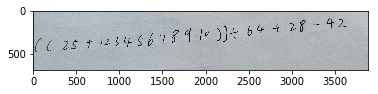

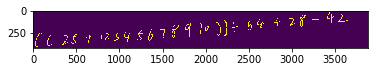

In [152]:
s = find_formula('15.jpg',200,50,extend=6)

In [153]:
np.array(s).shape

(1, 425, 3883)

d:\python3.6\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


['((25+12345678919))/64+28-42']

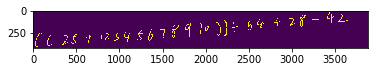

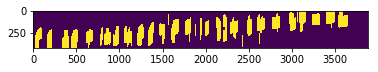

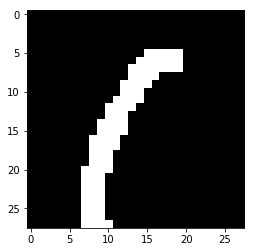

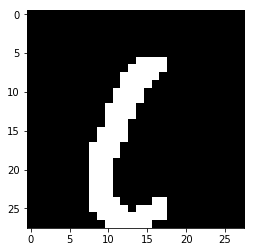

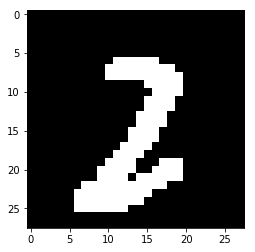

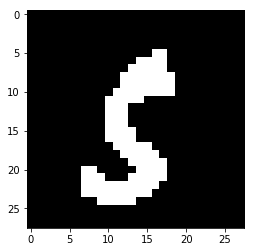

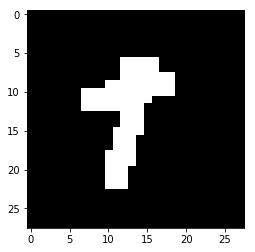

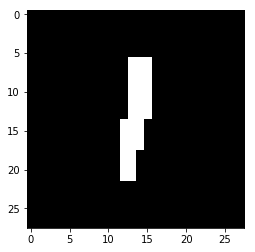

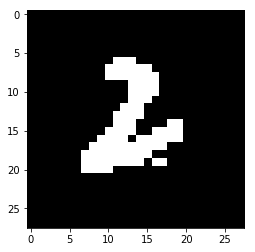

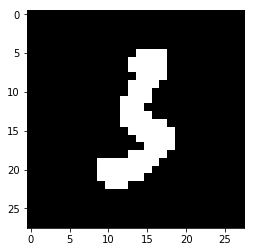

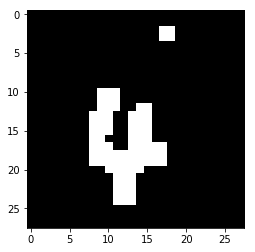

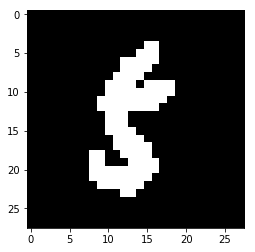

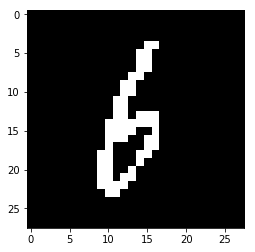

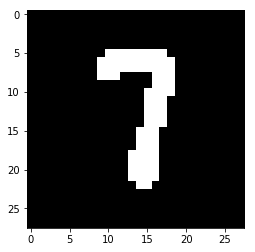

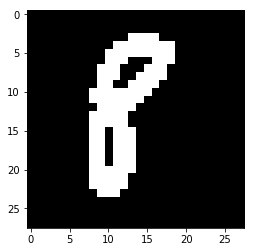

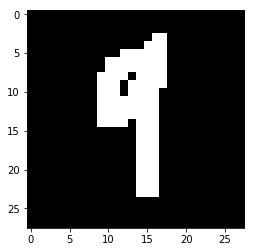

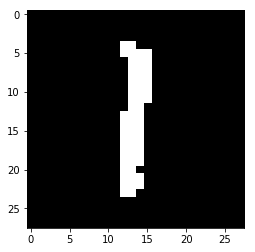

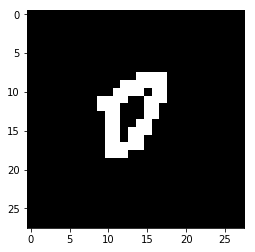

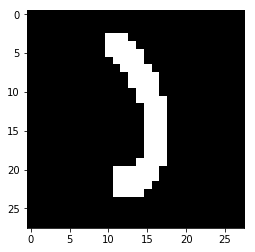

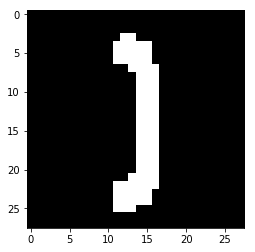

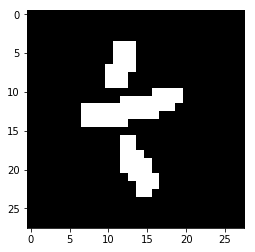

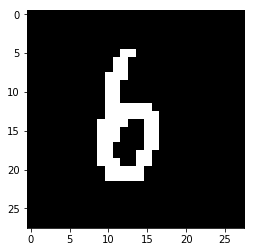

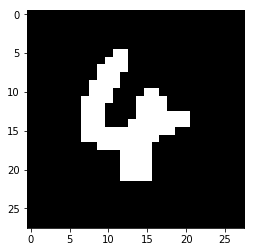

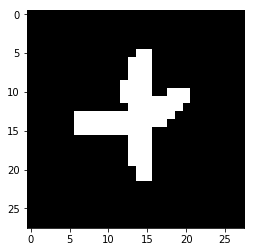

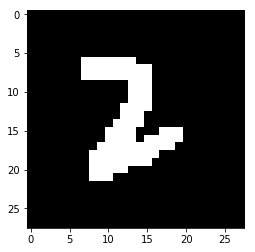

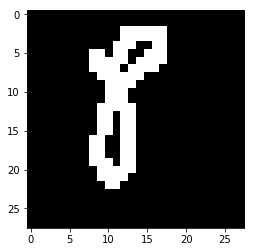

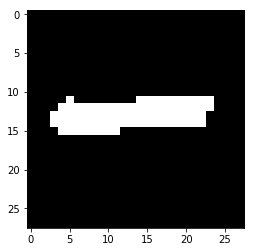

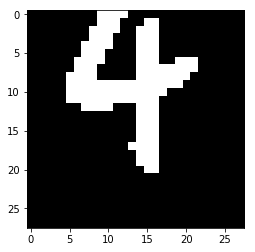

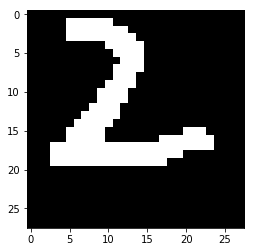

In [154]:
infer_image(s,args)

In [60]:
s[0][0][0][0]

141